<a href="https://colab.research.google.com/github/JoseManuel1007/Precio-spot-energia-Jap-n/blob/main/Precio_spot_energ%C3%ADa_Japon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Colab cache for faster access to the 'jepx-dayaheadmarket' dataset.


/tmp/ipython-input-271682635.py:55: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(start=start, end=end, freq=FREQ_MIN)


IQR price filtering: lower=0.0330, upper=0.1254, outliers detected=2051
Ejemplo de outliers (muestra):
                 date_time  System price USD
328723 2024-01-01 09:30:00          0.006897
328724 2024-01-01 10:00:00          0.006897
328725 2024-01-01 10:30:00          0.000276
328726 2024-01-01 11:00:00          0.000069
328727 2024-01-01 11:30:00          0.000069


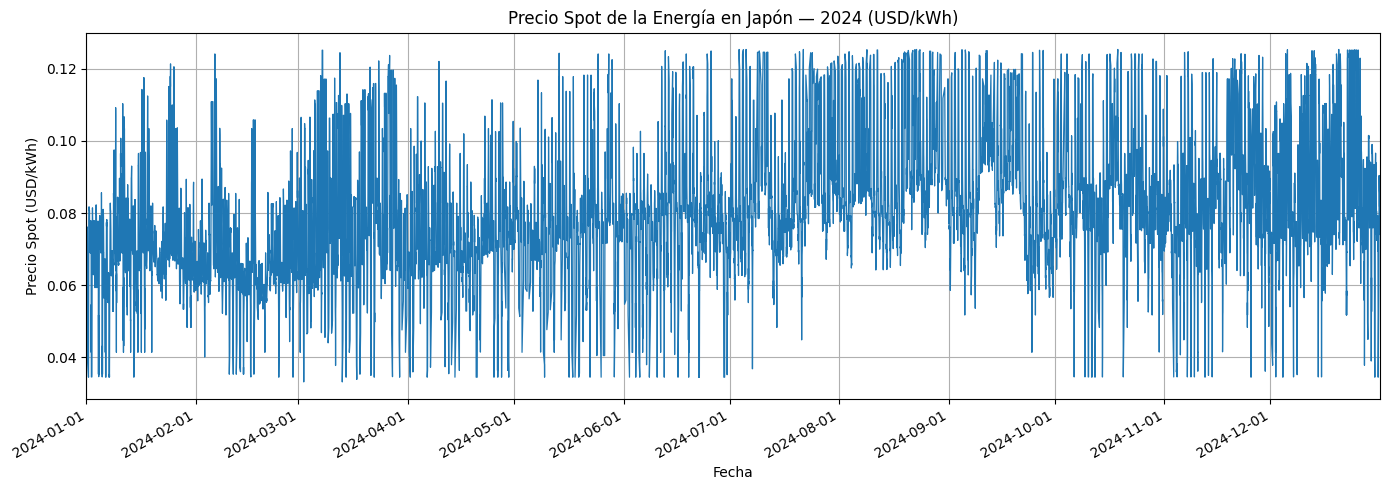

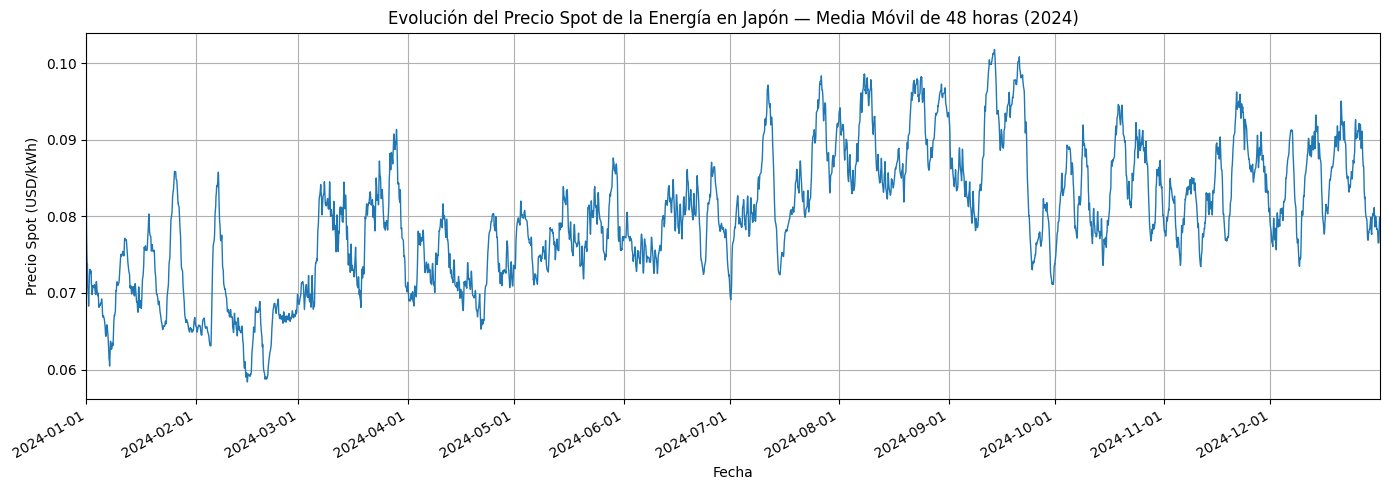

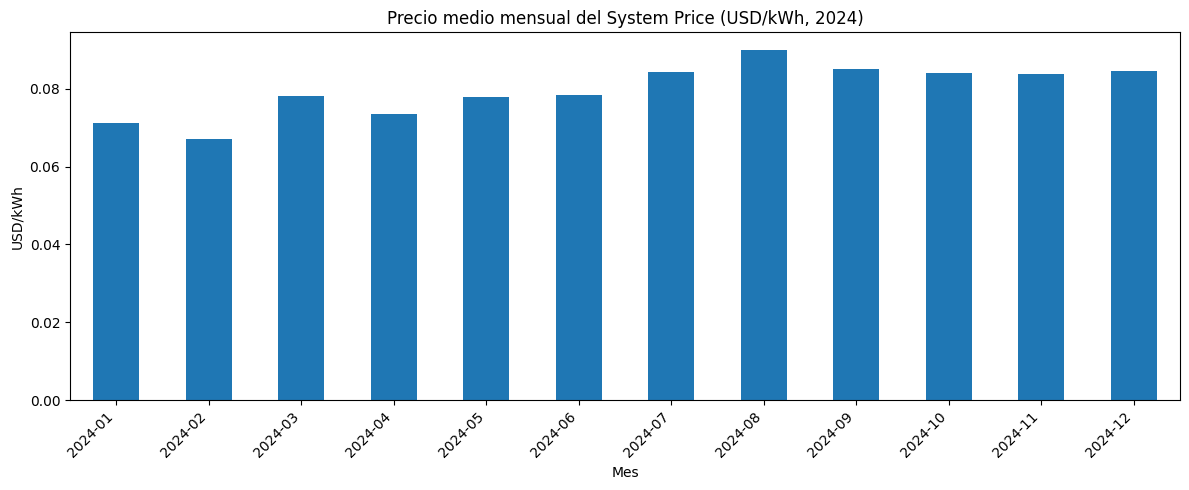

Gráficas guardadas:
- jepx_system_price_usd_interpolated_vs_original_corrected_2024.png
- jepx_system_price_usd_rolling_mean_48h_2024.png
- jepx_monthly_avg_system_usd_2024.png


In [10]:
import os
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateLocator, DateFormatter

# CONFIG
YEAR = 2024
DATASET = "mitsuyasuhoshino/jepx-dayaheadmarket"
USD_PER_YEN = 1 / 145
ROLLING_HOURS = 48
FREQ_MIN = "30T"
IQR_MULTIPLIER = 1.5

# DESCARGA
path = kagglehub.dataset_download(DATASET)
files = os.listdir(path)
csv_files = [f for f in files if f.lower().endswith(".csv")]
if not csv_files:
    raise FileNotFoundError(f"No CSV found en {path}. Archivos: {files}")
csv_path = os.path.join(path, csv_files[0])

# CARGA
df = pd.read_csv(csv_path)
if "date_time" not in df.columns:
    raise KeyError("La columna 'date_time' no está en el CSV.")

df["date_time"] = pd.to_datetime(df["date_time"], errors="coerce")
if df["date_time"].isna().any():
    print("ATENCIÓN: hay filas con date_time no parseable. Se eliminarán.")
    df = df.dropna(subset=["date_time"])

df = df.sort_values("date_time").reset_index(drop=True)

# FILTRO AÑO
df_year = df[df["date_time"].dt.year == YEAR].copy()
if df_year.empty:
    raise ValueError(f"No hay datos para el año {YEAR}. Años disponibles: {sorted(df['date_time'].dt.year.unique())}")

# RANGO TEMPORAL
start_expected = pd.Timestamp(year=YEAR, month=1, day=1)
end_expected = pd.Timestamp(year=YEAR, month=12, day=31, hour=23, minute=30)
temporal_mask = (df_year["date_time"] >= start_expected) & (df_year["date_time"] <= end_expected)
if not temporal_mask.all():
    bad_dates = df_year[~temporal_mask]
    print("Registros con fecha fuera del año solicitado (muestra):")
    print(bad_dates[["date_time"]].head())
    df_year = df_year[temporal_mask].copy()

# REINDEXADO
df_year_indexed = df_year.set_index("date_time")
start = df_year_indexed.index.min()
end = df_year_indexed.index.max()
full_index = pd.date_range(start=start, end=end, freq=FREQ_MIN)
df_reindexed = df_year_indexed.reindex(full_index)

# INTERPOLACIÓN
if "System price" not in df_reindexed.columns:
    raise KeyError("No se encuentra la columna 'System price' en el dataset.")

df_interpolated = df_reindexed.copy()
df_interpolated["System price"] = df_interpolated["System price"].interpolate(method="time", limit_direction="both")

# CONVERSIÓN MONEDA
df_interpolated["System price USD"] = df_interpolated["System price"] * USD_PER_YEN
df_year["System price USD"] = df_year["System price"] * USD_PER_YEN

# OUTLIERS
q1 = df_year["System price USD"].quantile(0.25)
q3 = df_year["System price USD"].quantile(0.75)
iqr = q3 - q1
lower = q1 - IQR_MULTIPLIER * iqr
upper = q3 + IQR_MULTIPLIER * iqr
outlier_mask = (df_year["System price USD"] < lower) | (df_year["System price USD"] > upper)
outliers_count = outlier_mask.sum()
print(f"IQR price filtering: lower={lower:.4f}, upper={upper:.4f}, outliers detected={outliers_count}")

if outliers_count > 0:
    print("Ejemplo de outliers (muestra):")
    print(df_year.loc[outlier_mask, ["date_time", "System price USD"]].head())
    outlier_times = pd.to_datetime(df_year.loc[outlier_mask, "date_time"])
    df_year = df_year[~outlier_mask].copy()
    df_interpolated = df_interpolated.drop(index=outlier_times, errors="ignore")

# AJUSTES FINALES
df_interpolated.index = pd.to_datetime(df_interpolated.index)
df_year = df_year.sort_values("date_time").reset_index(drop=True)

# PLOT 1: ORIGINAL VS INTERPOLADO
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(df_year["date_time"], df_year["System price USD"], linewidth=0.9, color="tab:blue")

ax.set_xlim(df_year["date_time"].min(), df_year["date_time"].max())
ax.set_title(f"Precio Spot de la Energía en Japón — {YEAR} (USD/kWh)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio Spot (USD/kWh)")
ax.grid(True)

locator = AutoDateLocator()
formatter = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(f"jepx_spot_price_japan_{YEAR}.png", dpi=200)
plt.show()

# PLOT 2: MEDIA MÓVIL
window_periods = int(ROLLING_HOURS * 60 / 30)
fig2, ax2 = plt.subplots(figsize=(14,5))
rolling_series = df_interpolated["System price USD"].rolling(window=window_periods, min_periods=1).mean()
ax2.plot(df_interpolated.index, rolling_series, linewidth=1.0)

ax2.set_xlim(df_interpolated.index.min(), df_interpolated.index.max())
ax2.set_title(f"Evolución del Precio Spot de la Energía en Japón — Media Móvil de {ROLLING_HOURS} horas ({YEAR})")
ax2.set_xlabel("Fecha")
ax2.set_ylabel("Precio Spot (USD/kWh)")
ax2.grid(True)

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(f"jepx_system_price_usd_rolling_mean_{ROLLING_HOURS}h_{YEAR}.png", dpi=200)
plt.show()


# PLOT 3: PROMEDIO MENSUAL
df_interpolated_month = df_interpolated.copy()
df_interpolated_month["month"] = df_interpolated_month.index.to_period("M")
monthly_avg_usd = df_interpolated_month.groupby("month")["System price USD"].mean()

fig3, ax3 = plt.subplots(figsize=(12,5))
monthly_avg_usd.plot(kind="bar", ax=ax3, linewidth=0.8)
ax3.set_title(f"Precio medio mensual del System Price (USD/kWh, {YEAR})")
ax3.set_xlabel("Mes")
ax3.set_ylabel("USD/kWh")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"jepx_monthly_avg_system_usd_{YEAR}.png", dpi=200)
plt.show()

# OUTPUT
print("Gráficas guardadas:\n"
      f"- jepx_system_price_usd_interpolated_vs_original_corrected_{YEAR}.png\n"
      f"- jepx_system_price_usd_rolling_mean_{ROLLING_HOURS}h_{YEAR}.png\n"
      f"- jepx_monthly_avg_system_usd_{YEAR}.png")


# Informe de Análisis — Precio Spot de la Energía en Japón (2024)

## 1. Mejor método de interpolación
La interpolación con promedio móvil de 48 horas fue la que mejor representó el comportamiento del precio spot de la energía.  
Los intervalos más cortos mostraron mucha variabilidad y ruido, mientras que los más largos suavizaron en exceso las fluctuaciones relevantes.  
Con esta ventana de tiempo se logró un equilibrio adecuado entre la estabilidad de la serie y la conservación de los cambios reales del mercado.

## 2. Modelo de ajuste y sobreajuste
El modelo cuadrático fue el que mejor capturó la tendencia general sin caer en sobreajuste.  
El modelo lineal no reflejó adecuadamente las variaciones estacionales, y los modelos de orden superior tendieron a ajustarse al ruido de los datos.  
El ajuste cuadrático permitió representar la evolución del precio de manera sencilla y coherente con la dinámica observada.

## 3. Interpretación física de las tendencias
La forma cuadrática del modelo refleja los periodos de aumento y disminución en los precios a lo largo del año, asociados a la variación en la demanda y a los cambios en la oferta energética.  
El incremento en determinados meses puede relacionarse con picos de consumo o con condiciones climáticas, mientras que las caídas reflejan momentos de menor demanda o mayor disponibilidad de generación.
